# Reinforcement learning for robotics
This is the initial notebook that you will need to fill out through the semester. 
### Setup
First let's make sure that everything is working properly:

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
assert gym.__version__=='1.0.0',"You need a newer version of gym"
print("Everything seems good")

Everything seems good


### Outline
As teaching a robot how to walk is tricky, you will first test your algorithm on a much simpler task: Balancing an inverted pendulum.
This week, you will:
- Setup a first enviromnent
- Run a random policy
- Modify the distribution of this policy

In [3]:
#create the environment
envname="InvertedPendulum-v5"
env = gym.make_vec(envname,1,render_mode='rgb_array',vectorization_mode='sync')

This environment is called InvertedPendulum, and is running in the Mujoco simulator. You can check what it can do by reading the [documentation](https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/)

Your first task is to find what are the state space and the action space. Additionally, answer the following questions:
- What is the dimension of the state space?
- What is the dimension of the action space?
- How could you get these dimentions directly in your code?
- When your ran these commands, you should have gotten an array of dimension 2. What does each of the dimension represent?

_Answers_: - What is the dimension of the state space? 4
- What is the dimension of the action space? 1   

In [4]:
obs, info = env.reset()
print("State space dimension:", env.single_observation_space.shape)
print("Action space dimension:", env.single_action_space.shape)

State space dimension: (4,)
Action space dimension: (1,)


### Visualization
Gymnasium is providing a visualisation function, let's try it

In [5]:
def render_notebook(env,id,title=""):
    clear_output(wait=True)
    plt.imshow(env.render()[id])
    plt.axis('off')
    plt.tight_layout()
    plt.title(title)
    plt.show()
    plt.pause(0.1)

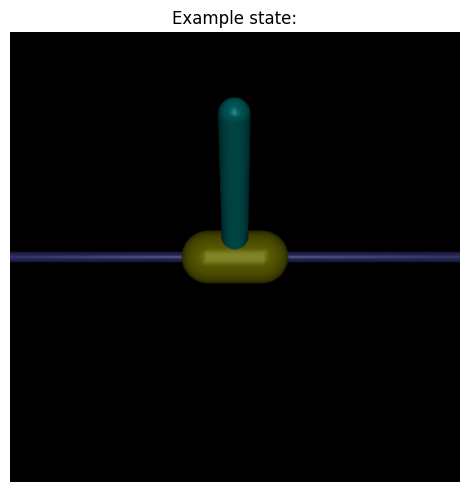

In [ ]:
obs, info = env.reset()
render_notebook(env, 0, "Example state:")


Nice right?

### Random policy
Now you will try to implement a random policy: Uniformely chose a random action at each time step.

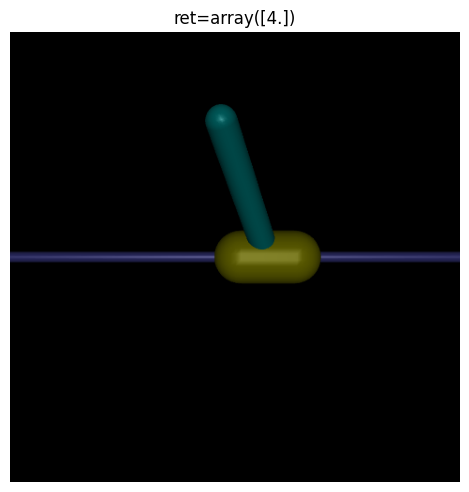

In [ ]:
terminated = [False]
env.reset()
ret=0
while not all(terminated):
    action = np.random.uniform(-3, 3, size=(1, 1))
    _,reward, terminated,truncated,info = env.step(action)
    terminated = terminated|truncated
    ret+=reward
    render_notebook(env,0,f"{ret=}")

### Other distribution
This policy is quite terrible, so let's try to improve it by using a gaussian distribution instead. Test several standard deviations and see which one works best

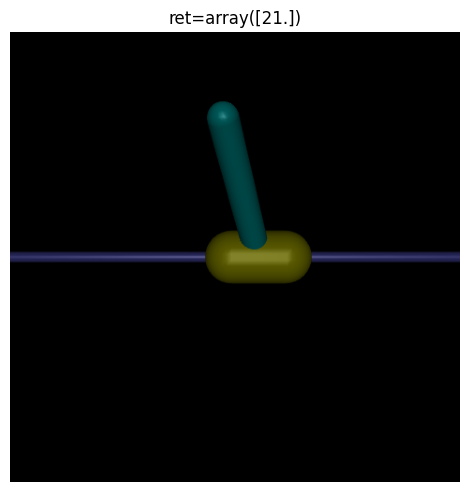

In [ ]:

terminated = [False]
std = 0.1
env.reset()
ret=0
while not all(terminated):
    action = np.random.normal(0, std, size=(1, 1))
    _,reward, terminated,truncated,info = env.step(action)
    terminated = terminated|truncated
    ret+=reward
    render_notebook(env,0,f"{ret=}")

This concludes this first part of the project, next week we will try to implement a feedback controler in this system. 
In the meantime, feel free to get more confortable with the documentation of gymnasium

FeedBack Policy u=-Kx avec K a determiner

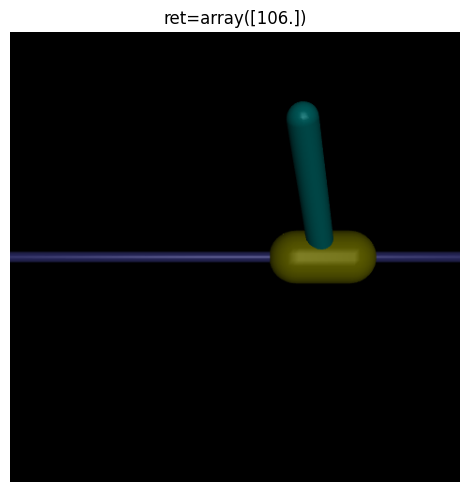

In [ ]:
K = np.array([[-1.0 , -2.0, -3.0, -4.0]]) 
terminated = [False]
env.reset()
ret=0
while not all(terminated):
    action = -np.dot(K, obs.T)
    obs,reward, terminated,truncated,info = env.step(action)
    terminated = terminated|truncated
    ret+=reward
    render_notebook(env,0,f"{ret=}")
    

In [9]:
def simulate(K):
    obs, info = env.reset()
    terminated = [False]
    ret = 0
    while not all(terminated):
        action = -np.dot(K, obs.T)
        obs, reward, terminated, truncated, info = env.step(action)
        terminated = terminated | truncated
        ret += reward
    return ret

bret = -np.inf  
bK = None
num = 10000
for i in range(num):
    K_cand = np.random.uniform(low=-5, high=5, size=(1, 4))
    cret = simulate(K_cand)
    if cret > bret:
        bret = cret
        bK = K_cand 
    if np.isclose(cret.item(), 1000.0):
        print(f"Iteration {i}: reward = {cret}, best reward = {bret}")
        break
    print(f"Iteration {i}: reward = {cret}, best reward = {bret}")

print(f"Best K found : {bK}", f"best Reward = {bret}")


Iteration 0: reward = [19.], best reward = [19.]
Iteration 1: reward = [5.], best reward = [19.]
Iteration 2: reward = [39.], best reward = [39.]
Iteration 3: reward = [4.], best reward = [39.]
Iteration 4: reward = [5.], best reward = [39.]
Iteration 5: reward = [22.], best reward = [39.]
Iteration 6: reward = [6.], best reward = [39.]
Iteration 7: reward = [15.], best reward = [39.]
Iteration 8: reward = [70.], best reward = [70.]
Iteration 9: reward = [24.], best reward = [70.]
Iteration 10: reward = [20.], best reward = [70.]
Iteration 11: reward = [279.], best reward = [279.]
Iteration 12: reward = [112.], best reward = [279.]
Iteration 13: reward = [9.], best reward = [279.]
Iteration 14: reward = [7.], best reward = [279.]
Iteration 15: reward = [7.], best reward = [279.]
Iteration 16: reward = [57.], best reward = [279.]
Iteration 17: reward = [7.], best reward = [279.]
Iteration 18: reward = [76.], best reward = [279.]
Iteration 19: reward = [31.], best reward = [279.]
Iterati

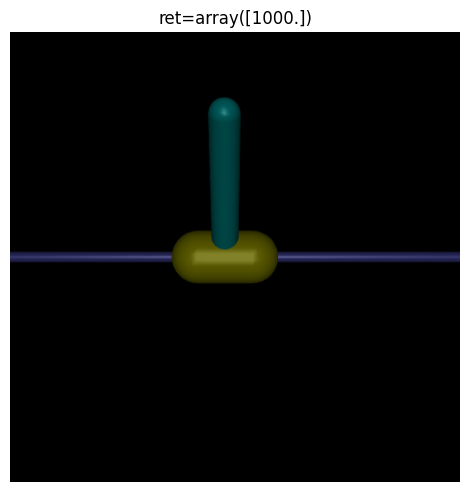

In [8]:
obs, info = env.reset()
terminated = [False]
ret = 0

while not all(terminated):
    action = -np.dot(bK, obs.T)
    obs, reward, terminated, truncated, info = env.step(action)
    terminated = terminated | truncated
    ret += reward
    render_notebook(env, 0, f"{ret=}")